In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
#fname = rates_npops_4_nmodels_1_npts_4096_seed_111
fname = 'rates_npops_2_nmodels_128_npts_64_seed_112_ws_0.5_hs_1'

data = xr.open_dataset(f'data/{fname}.nc')
print(data.sizes)

data = data.stack(mp=('model','point'), create_index=False)
data = data.assign_coords(mp=np.arange(data.sizes['mp']))
data = data.transpose('mp', 'pop', 'pop_in')

X = data['H']
X = torch.from_numpy(X.values).type(torch.float)

y = data['R'].sel(pop=0)
y = torch.from_numpy(y.values).type(torch.float)
y = y.view(-1, 1)

Frozen({'model': 128, 'point': 64, 'pop': 2, 'pop_in': 2})


In [ ]:
W = data['W'].values.reshape(-1, 4)
W = torch.from_numpy(W).type(torch.float)

# Add weights of the rate model to the feature vector
X = torch.cat((X, W), dim=1)

In [ ]:
df = pd.DataFrame(X.numpy(), columns=[f'Feature_{i}' for i in range(X.shape[1])])
df['Target'] = y.numpy()
df

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Target
0,0.341551,0.591946,0.738865,0.291757,-0.657968,0.242816,1.107280
1,-0.699415,-0.270246,0.738865,0.291757,-0.657968,0.242816,0.890017
2,-0.507147,1.048893,0.738865,0.291757,-0.657968,0.242816,0.579928
3,1.273731,-0.543263,0.738865,0.291757,-0.657968,0.242816,3.785744
4,0.094720,-0.850640,0.738865,0.291757,-0.657968,0.242816,1.935771
...,...,...,...,...,...,...,...
8187,-0.264731,-1.176816,-0.296864,1.079197,-0.065031,0.212963,2.976027
8188,-1.368512,-0.533598,-0.296864,1.079197,-0.065031,0.212963,2.166126
8189,1.813943,-0.870056,-0.296864,1.079197,-0.065031,0.212963,4.732441
8190,0.836208,0.243753,-0.296864,1.079197,-0.065031,0.212963,3.854016


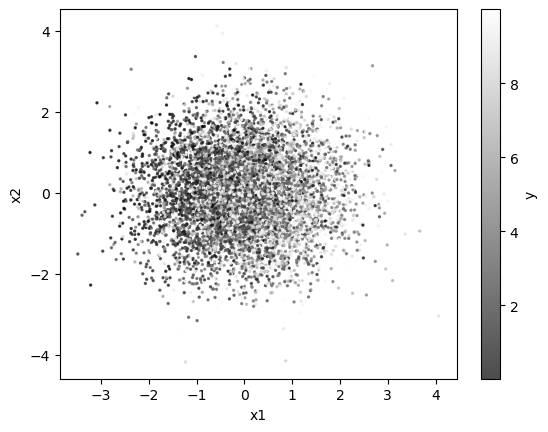

In [ ]:
# Plot two feaures with greyscale colors based on the output
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='gray', alpha=0.7, s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='y')
plt.show()

In [ ]:
# Split the data into train and test sets (80% train, 20% test)
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=222)

n_total = X.shape[0]
n_train = int(0.8 * n_total)

X_train = X[:n_train, :]
y_train = y[:n_train, :]
X_test = X[n_train:, :]
y_test = y[n_train:, :]

In [ ]:
torch.manual_seed(0)

# Hyper-parameters
BATCH_SIZE = 256
LR = 1e-3
EPOCHS = 1000
HIDDEN_SZ = 64

n_samples = X_train.shape[0]
n_feat = X_train.shape[1]

dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

X_test = X_test.to(device)
y_test = y_test.to(device)

# Define the model
model = nn.Sequential(
    nn.Linear(n_feat, HIDDEN_SZ),
    nn.Tanh(),
    nn.Linear(HIDDEN_SZ, HIDDEN_SZ),
    nn.Tanh(),
    #nn.Linear(HIDDEN_SZ, HIDDEN_SZ),
    #nn.Tanh(),
    nn.Linear(HIDDEN_SZ, 1)
).to(device)

# Loss + optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(1, EPOCHS + 1):
    model.train()   # switch to training mode

    train_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= n_samples

    if epoch % 40 == 0 or epoch == 1:
        # Testing
        model.eval()   # switch to evaluation mode
        with torch.inference_mode():
            pred = model(X_test)
            test_loss = loss_fn(pred, y_test)

        print(f'Epoch: {epoch:3d}/{EPOCHS}, '
              f'Train loss: {train_loss:.5f} ',
              f'Test loss: {test_loss:.5f}', flush=True)

Epoch:   1/1000, Train loss: 32.55181  Test loss: 24.37086
Epoch:  40/1000, Train loss: 0.45838  Test loss: 0.76475
Epoch:  80/1000, Train loss: 0.14776  Test loss: 0.27576
Epoch: 120/1000, Train loss: 0.08114  Test loss: 0.22553
Epoch: 160/1000, Train loss: 0.05234  Test loss: 0.17502
Epoch: 200/1000, Train loss: 0.03600  Test loss: 0.13481
Epoch: 240/1000, Train loss: 0.02463  Test loss: 0.11588
Epoch: 280/1000, Train loss: 0.01911  Test loss: 0.09998
Epoch: 320/1000, Train loss: 0.01523  Test loss: 0.09044
Epoch: 360/1000, Train loss: 0.01254  Test loss: 0.10056
Epoch: 400/1000, Train loss: 0.01171  Test loss: 0.09520
Epoch: 440/1000, Train loss: 0.01042  Test loss: 0.09951
Epoch: 480/1000, Train loss: 0.00806  Test loss: 0.09830
Epoch: 520/1000, Train loss: 0.00749  Test loss: 0.10001
Epoch: 560/1000, Train loss: 0.00743  Test loss: 0.09803
Epoch: 600/1000, Train loss: 0.00563  Test loss: 0.09419
Epoch: 640/1000, Train loss: 0.00604  Test loss: 0.10291
Epoch: 680/1000, Train loss: 

In [ ]:
sz = 10
nfeat = X.shape[1]
x = np.linspace(-3, 3, sz)
grids = np.meshgrid(*((x,) * nfeat))
Xtest = np.stack([g.ravel() for g in grids], axis=1)
Xtest = torch.from_numpy(Xtest).type(torch.float)

model.eval()   # switch to evaluation mode
with torch.inference_mode():
    ytest = model(Xtest.to(device))

ytest = ytest.cpu().numpy().reshape((sz,) * nfeat)

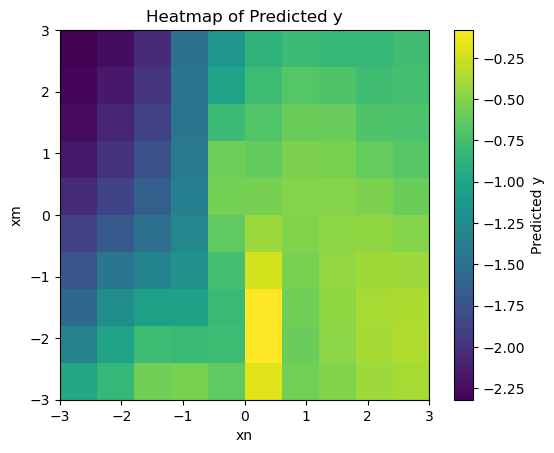

In [ ]:
plt.figure()
ext = (-3, 3, -3, 3)
m = 0
n = 3
cc = [0] * nfeat
cc[m], cc[n] = slice(None), slice(None)
plt.imshow(ytest[*cc], extent=ext, origin='lower', cmap='viridis')
plt.colorbar(label='Predicted y')
plt.xlabel('xn')
plt.ylabel('xm')
plt.title('Heatmap of Predicted y')
plt.show()

In [ ]:
""" # Evaluate / visualize
model.eval()
with torch.no_grad():
    yhat = model(X.to(device)).cpu()

# Get default plot colors
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

x_ = x.numpy()
Y = y.reshape(N, N).numpy()
Yhat = yhat.reshape(N, N).numpy()

plt.figure()
idx = np.linspace(0, N - 1, 10, dtype=int)
for n, ind in enumerate(idx):
    plt.scatter(x_, Y[ind, :], s=10, alpha=0.5, c=cols[n])
    plt.plot(x_, Yhat[ind, :], color=cols[n])
plt.show() """

" # Evaluate / visualize\nmodel.eval()\nwith torch.no_grad():\n    yhat = model(X.to(device)).cpu()\n\n# Get default plot colors\ncols = plt.rcParams['axes.prop_cycle'].by_key()['color']\n\nx_ = x.numpy()\nY = y.reshape(N, N).numpy()\nYhat = yhat.reshape(N, N).numpy()\n\nplt.figure()\nidx = np.linspace(0, N - 1, 10, dtype=int)\nfor n, ind in enumerate(idx):\n    plt.scatter(x_, Y[ind, :], s=10, alpha=0.5, c=cols[n])\n    plt.plot(x_, Yhat[ind, :], color=cols[n])\nplt.show() "